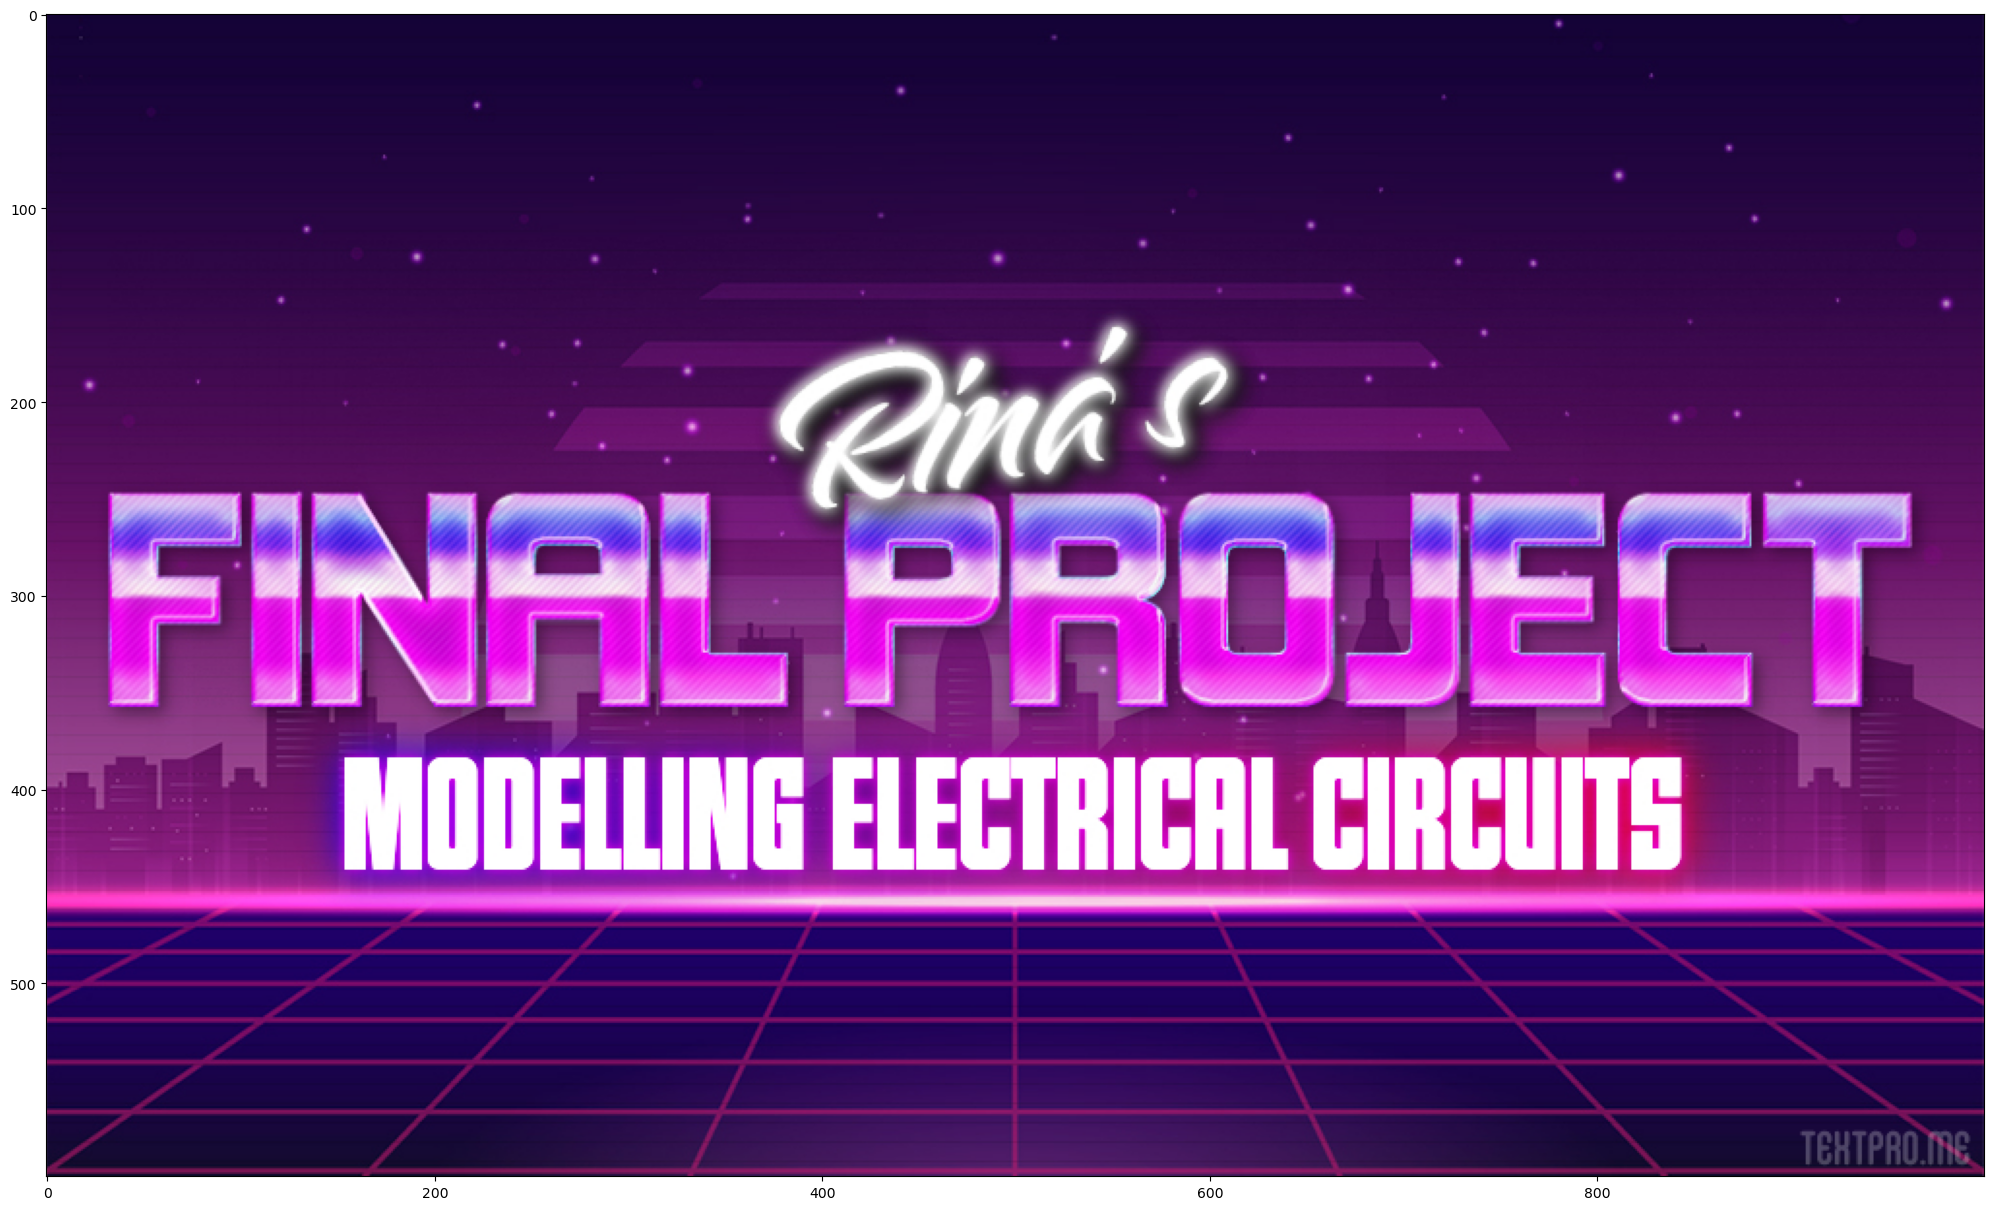

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import schemdraw
import schemdraw.elements as elm
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
plt.figure(figsize = (25,25))
plt.imshow(mpimg.imread("title.jpg"))
plt.show()

# Here is where I import the data and format it into multiple data structures.
This first block is where I read the data and set up the coordinate dictionary

## Completed at the end of this block: 
* Data is in an numpy array of strings (data)
* The number of nodes is stored in an int (num_nodes)
* Coordinates are stored in a dictionary (coord)
    * keys: node_ids as strings 
    * values: lists of doubles
* Node IDs in a list at the same indices as in the dictionary (node_ids)
* Processed lines from data array are removed

In [2]:
file_name = "final2023.txt"
data = np.array(open(file_name, "r").readlines()) # Data imported into a numpy array

num_nodes = int(data[0].replace("\n","")) # The first value is the number of nodes
coord = {} # Stores all of the coordinates in a dictionary sorted by the node_id
node_ids = [] # List so index of the node_id can be accessed in the dictionary

# Removes the spaces in the array
for i in range(1, num_nodes+1):
    coord.update({data[i].split(" ")[0]: data[i].split(" ")[1:]}) 
    node_ids.append(data[i].split(" ")[0]) # The node_id is appended to the node_ids list


# Removes the "\n" and type-casts all values to ints
for i in coord:
    for j in range(len(coord.get(i))):
        coord.get(i)[j] = float(coord.get(i)[j].replace("\n",""))
print("What the coordinate dictionary looks like currently: \n" + str(coord))
data = np.delete(data, np.arange(0, num_nodes + 1)) # Removes processed data from the array


What the coordinate dictionary looks like currently: 
{'NNE1': [3.83, 9.24], 'ENE1': [9.24, 3.83], 'ESE1': [9.24, -3.83], 'SSE1': [3.83, -9.24], 'SSW1': [-3.83, -9.24], 'WSW1': [-9.24, -3.83], 'WNW1': [-9.24, 3.83], 'NNW1': [-3.83, 9.24], 'NNE2': [1.91, 4.62], 'ENE2': [4.62, 1.91], 'ESE2': [4.62, -1.91], 'SSE2': [1.91, -4.62], 'SSW2': [-1.91, -4.62], 'WSW2': [-4.62, -1.91], 'WNW2': [-4.62, 1.91], 'NNW2': [-1.91, 4.62], 'CENTER': [0.0, 0.0]}




## At the end of this block:

* The number of edges is stored in an int (num_edges)
* Node-Arc Incidence Matrix stored in a numpy array (a)
    * Start node is denoted by -1, end node is denoted by 1
    * Rows represent edges, columns represent nodes
* Resistance Matrix stored in a numpy array (r)
    * Resistances on the diagonal, square matrix of edges
* Source connections stored in a dictionary (source_connect)
    * Index of row in Node-Arc Incidence Matrix as key
    * Replacement value as values
* Source Node stored as a list of the ID and the voltage (v0)
* Sink Node stored as a string of the node ID (sink)

In [3]:
num_edges = int(data[0]) # The first remaining value is the number of edges
data = np.delete(data, 0) # Since it has been processed, it's safe to be removed
a = np.zeros((num_edges, num_nodes)) # The node-arc incidence matrix
r = np.diagflat(np.ones(num_edges)) # The resistance matrix
source_connect = {} # Keeps track of where the source connects to update the rhs later

v0 = [data[num_edges].split(" ")[0], int(data[num_edges].split(" ")[-1])] # Source node
sink = data[num_edges+1].split(" ")[0].replace("\n", "") # Sink node
for i in range(0, num_edges):
    curr = data[i].split(" ") # Creates a list that can be more easily accessed
    start = int(node_ids.index(curr[0])) # Start node_id index of the edge
    end = int(node_ids.index(curr[1])) # End node_id index of the edge
    
    a[i, start] = -1 # Updates start node in the node-arc array
    a[i, end] = 1 # Updates end node in the node-arc array
    
    
    if (curr[0] == v0[0]): # If the source node is the start of the current edge
        source_connect.update({i : v0[1]})
    if (curr[1] == v0[0]): # If the source node is the end of the current edge
        source_connect.update({i : -v0[1]})
    
    resistance = int(curr[2].replace("\n","")) # resistance of the current edge
    r[i] = r[i] * resistance # Updates the edge in the resistance array

print("Node-arc Incidence Matrix: \n"+str(a)+"\n")
print("Resistance Matrix: \n"+str(r)+"\n")
print("Source-Connection Dictionary: "+str(source_connect))


Node-arc Incidence Matrix: 
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.


Checking the Source and Sink variables:


In [4]:
print("Source Index:",v0[0],"at coordinates", coord.get(v0[0]), "with", v0[1], "volts")
print("Sink Index:", sink, "at coordinates", coord.get(sink))


Source Index: NNW1 at coordinates [-3.83, 9.24] with 10 volts
Sink Index: SSW1 at coordinates [-3.83, -9.24]


## Schematic from data reading

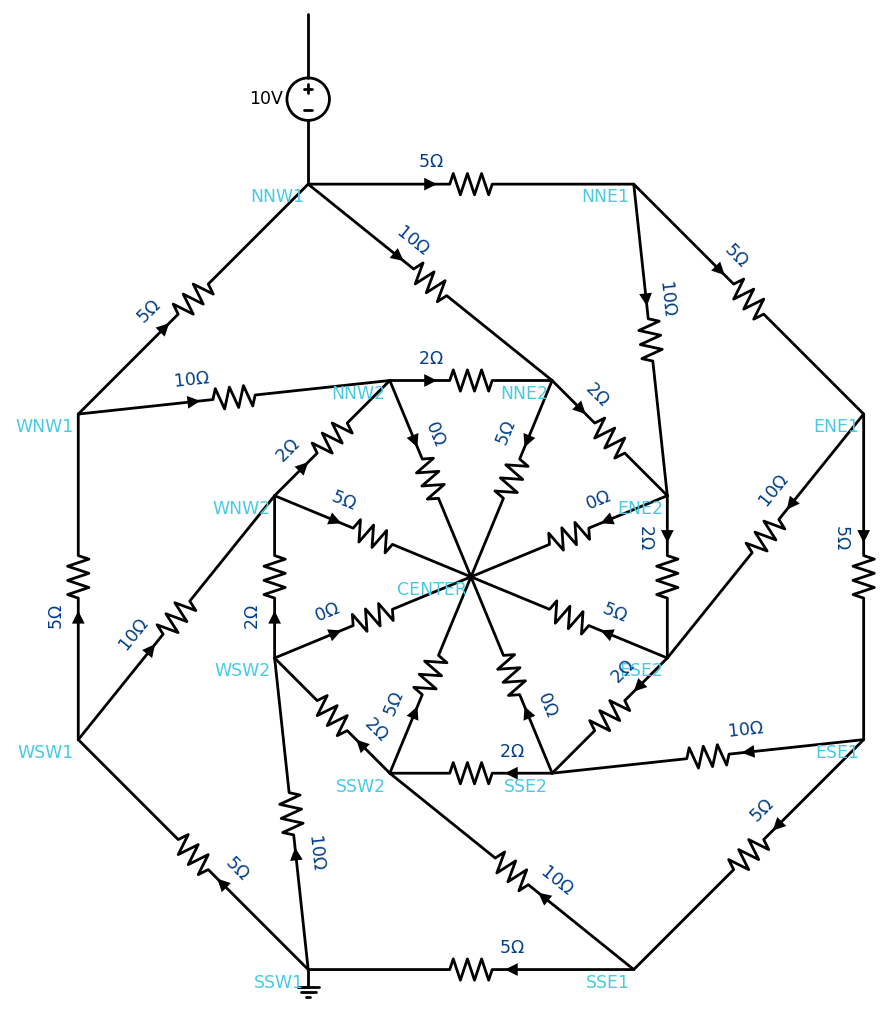

In [5]:
schematic = schemdraw.Drawing() # Instantiates the drawing
ynew = 4
if (coord.get(v0[0])[1] < 0):
    ynew = -4
schematic += elm.SourceV().endpoints(coord.get(v0[0]), (coord.get(v0[0])[0], 
coord.get(v0[0])[1]+ynew)).label(str(v0[1])+'V') # Creates the source at the v0 node

for i in coord.keys():
    schematic += elm.Line().endpoints(coord.get(i), 
    coord.get(i)).label(i, color = "#48cae4", loc = "center") 
    # Creates a node at each coordinate
schematic += elm.Ground().at(coord.get(sink)) # Creates the sink node at the given node_id

for i in range(num_edges):
    index=[coord.get(node_ids[list(a[i]).index(-1)]),coord.get(node_ids[list(a[i]).index(1)])]
    schematic += (R1 := elm.Resistor().endpoints(index[0], index[1])) 
    # Resistance is found at the diagonal of the given indices
    schematic += elm.CurrentLabelInline(direction='in').at(R1).label('$'+
            str(int(r[i,i]))+'\Omega$', rotate = True , color = "#023e8a")
    # Resistance is found at the diagonal of the given 
schematic.draw()


# Concatenating the matrices
* The original linear system is
$$\begin{pmatrix}A & R\cr 0 & A^T\cr\end{pmatrix}
\begin{pmatrix}v\cr c\cr\end{pmatrix}=0\newline$$


* However,  $v_0$ and $v_n$ are already known, so the columns of the Node-Arc Incidence Matrix and transfer them to the zero vector
    * Using the source connection dictionary, the corresponding rows of the zero vector are updated to include the source voltage
* The source and sink currents do not sum to zero, so the corresponding rows are removed

In [6]:
a1 = np.delete(a, [node_ids.index(v0[0]), node_ids.index(sink)], axis = 1)
arr1 = np.concatenate([a1,r], axis = 1, dtype = float) # Top row of the array is concatenated
arr2 = np.concatenate([np.zeros((num_nodes-2, num_nodes-2)), a1.T], axis = 1, dtype = float) 
# Bottom row of the array is concatenated
arr = np.concatenate([arr1, arr2], axis = 0, dtype = float) # Top and bottom rows concatenated
rhs = np.zeros(num_nodes + num_edges - 2) # Solution is 0s
start_node = [node_ids.index(v0[0])]
# Fix the rhs using the source_connect dictionary
for i in source_connect:
    rhs[i] = source_connect.get(i)

#rhs[:4] = rhs[:4] - (a[:, node_ids.index(v0[0])]) * v0[1]

print(arr)  
print(rhs)


[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]
 [ 0.  0.  0. ...  1.  1.  1.]]
[  0.   0.   0.   0.   0.   0. -10.  10.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]


In [7]:
print("Source Connect Dictionary: "+str(source_connect))
print("Updated Zero Vector: "+str(rhs))

Source Connect Dictionary: {6: -10, 7: 10, 23: 10}
Updated Zero Vector: [  0.   0.   0.   0.   0.   0. -10.  10.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]


# Singular Value Decomposition of System

In [8]:
# Singular Value Decomposition
u, s, vt = np.linalg.svd(arr)
utb = u.T @ rhs / s
soln = sum(utb[i] * vt[i] for i in range(len(utb)))

# Formatting the voltages
if (node_ids.index(v0[0]) < node_ids.index(sink)):
    voltages = soln[:node_ids.index(v0[0])] # Everything before the source node
    voltages = np.append(voltages, v0[1]) # Source node
    voltages = np.append(voltages, soln[node_ids.index(v0[0]):node_ids.index(sink)-1]) 
    # Between
    voltages = np.append(voltages, 0) # Sink node
    voltages = np.append(voltages, soln[node_ids.index(sink)-1:num_nodes-2]) 
    # Everything before the sink node
else:
    voltages = soln[:node_ids.index(sink)] # Everything before the source node
    voltages = np.append(voltages, 0) # Source node
    voltages = np.append(voltages, soln[node_ids.index(sink):node_ids.index(v0[0])-1]) 
    # Between
    voltages = np.append(voltages, v0[1]) # Sink node
    voltages = np.append(voltages, soln[node_ids.index(v0[0])-1:num_nodes-2]) 
    # Everything before the sink node

currents = soln[num_nodes-2:] # Currents

# Printing the x vector to check
print("Voltages")
for i in range(num_nodes):
    print(node_ids[i], str(voltages[i]), "volts")
print("\nCurrents")
for i in range(num_edges):
    print(node_ids[list(a[i]).index(-1)], "-->", node_ids[list(a[i]).index(1)], currents[i], "amps")
    

Voltages
NNE1 7.23924706085133 volts
ENE1 5.62126097916563 volts
ESE1 4.311373805129224 volts
SSE1 2.680316860694762 volts
SSW1 0.0 volts
WSW1 3.5299229393641065 volts
WNW1 6.402711844930733 volts
NNW1 10.0 volts
NNE2 5.341889242392685 volts
ENE2 4.953713345925405 volts
ESE2 5.0050631638669545 volts
SSE2 4.953713345925395 volts
SSW2 4.778836693215343 volts
WSW2 4.9537133459253955 volts
WNW2 4.844191006959154 volts
NNW2 4.953713345925399 volts
CENTER 4.95371334592541 volts

Currents
NNE1 --> ENE1 0.32359721633713984 amps
ENE1 --> ESE1 0.26197743480727625 amps
ESE1 --> SSE1 0.32621138888689527 amps
SSE1 --> SSW1 0.5360633721389536 amps
SSW1 --> WSW1 -0.7059845878728233 amps
WSW1 --> WNW1 -0.5745577811133217 amps
WNW1 --> NNW1 -0.7194576310138558 amps
NNW1 --> NNE1 0.5521505878297354 amps
NNE2 --> ENE2 0.19408794823364622 amps
ENE2 --> ESE2 -0.025674908970771376 amps
ESE2 --> SSE2 0.02567490897079272 amps
SSE2 --> SSW2 0.08743832635502907 amps
SSW2 --> WSW2 -0.08743832635502041 amps
WSW2 

# Definition of the Schematic Drawing

In [9]:
def draw_schem(vers, schematic):
    ynew = 4
    if (coord.get(v0[0])[1] < 0):
        ynew = -4
    schematic += elm.SourceV().endpoints(coord.get(v0[0]), (coord.get(v0[0])[0], 
    coord.get(v0[0])[1]+ynew)).label(str(v0[1])+'V') 
    # Creates the source at the v0 node
    for i in coord.keys(): # Node IDs
        if vers.lower() == "voltage":
            schematic += elm.Line().endpoints(coord.get(i), coord.get(i)).label(i+
            " - "+str(voltages[node_ids.index(i)])[:3]+"V", color = "#48cae4", loc = "center")
        else :
            schematic += elm.Line().endpoints(coord.get(i), coord.get(i)).label(i,
                                                color = "#48cae4", loc = "center") 
        # Creates a node at each coordinate
        schematic += elm.Ground().at(coord.get(sink)) 
        # Creates the sink node at the given node_id
    
    for i in range(num_edges): 
        index=[coord.get(node_ids[list(a[i]).index(-1)]),
                coord.get(node_ids[list(a[i]).index(1)])]
            # Index of edges found by which indices of the node-arc array are -1 and 1
        if vers.lower() == "current":
            schematic += (R1 := elm.Resistor().endpoints(index[0], index[1])).label('$'+
            str(int(r[i,i]))+'\Omega$', loc = "bottom", color = "#023e8a") 
            # Resistance is found at the diagonal of the given indices
            schematic += elm.CurrentLabelInline(direction='in').at(R1).label(
                str(currents[i])[:5], color = "#0096c7", rotate = True)
        else:
            schematic += (R1 := elm.Resistor().endpoints(index[0], index[1]))

    return schematic

## Voltage Drawing

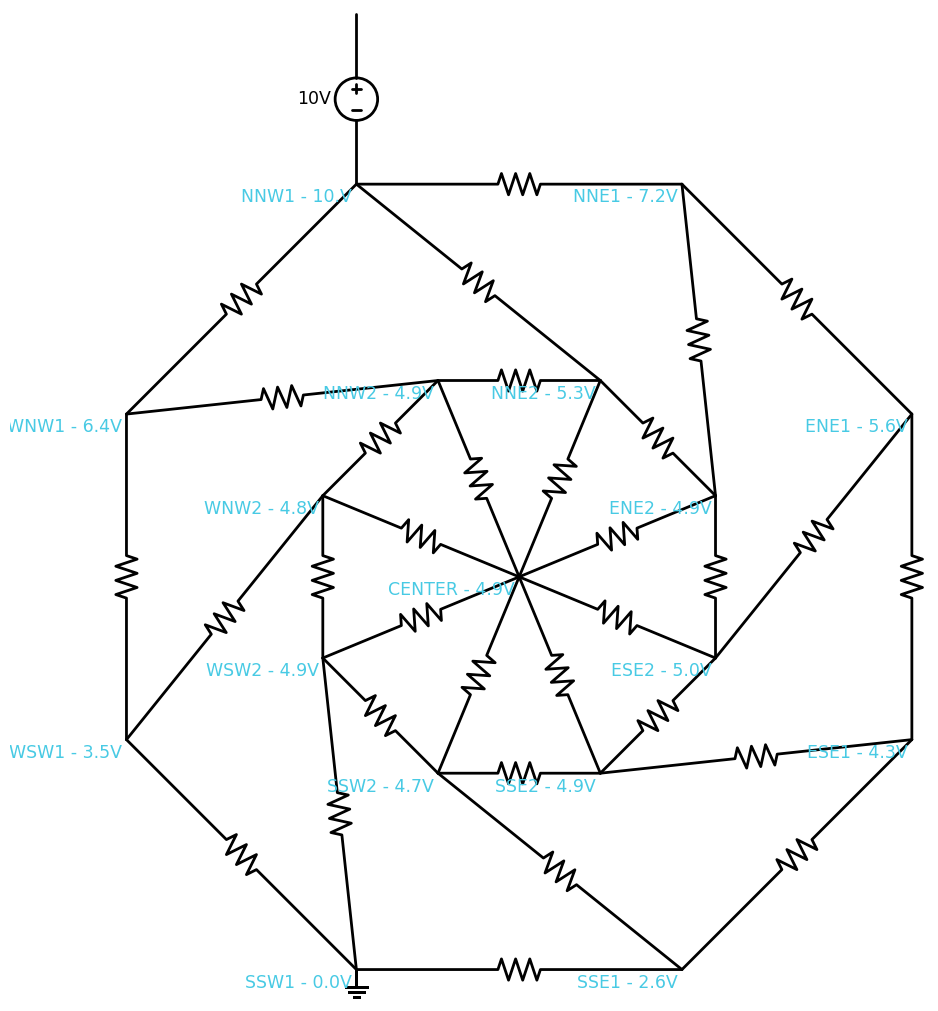

In [10]:
draw_schem("voltage", schemdraw.Drawing()).draw()

## Current Drawing

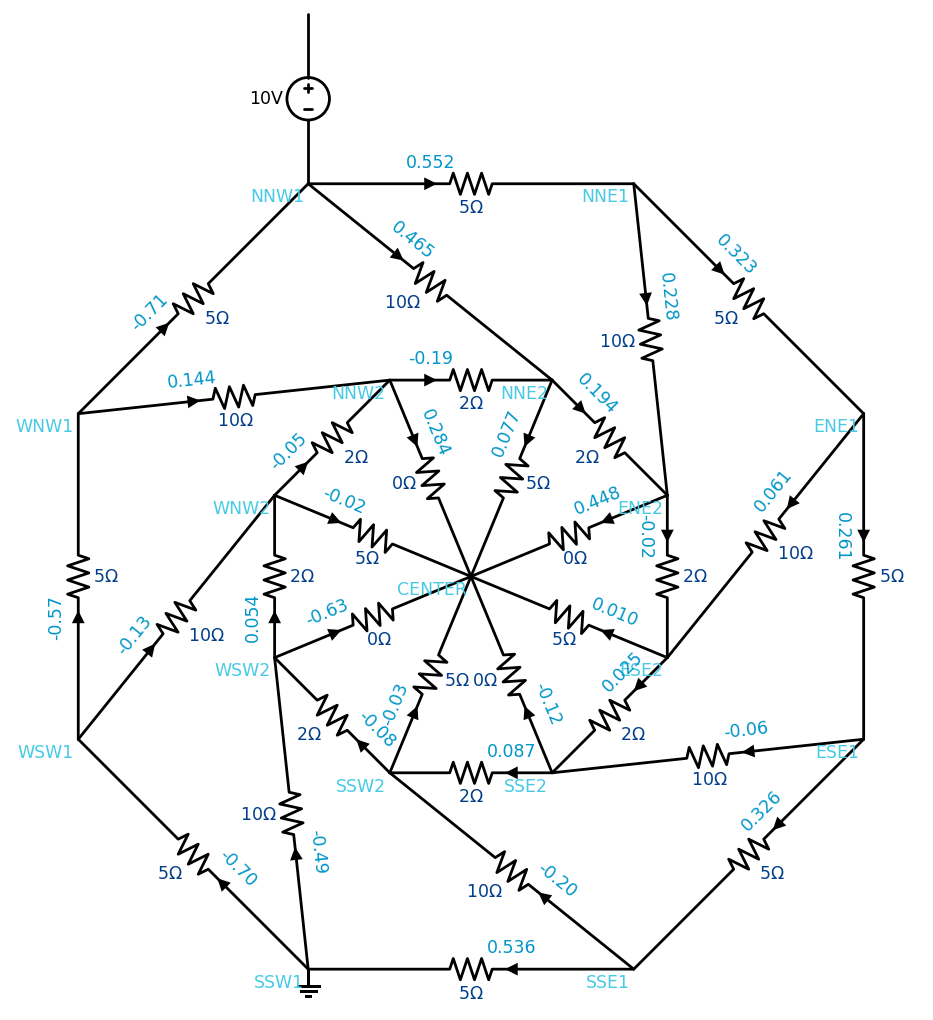

In [11]:
draw_schem("current", schemdraw.Drawing()).draw()

# Verification:
The voltage drop along each edge is equal to the current times the resistance

$$Av=-Rc$$

In [12]:
print("Predicted: " + str(a @ voltages)+"\n")
print("Expected: "+str(-r @ currents)+"\n")
print("Residuals: "+str(a @ voltages + r @ currents))

Predicted: [-1.61798608e+00 -1.30988717e+00 -1.63105694e+00 -2.68031686e+00
  3.52992294e+00  2.87278891e+00  3.59728816e+00 -2.76075294e+00
 -3.88175896e-01  5.13498179e-02 -5.13498179e-02 -1.74876653e-01
  1.74876653e-01 -1.09522339e-01  1.09522339e-01  3.88175896e-01
 -2.28553371e+00 -6.16197815e-01  6.42339541e-01  2.09851983e+00
  4.95371335e+00  1.31426807e+00 -1.44899850e+00 -4.65811076e+00
 -3.88175896e-01  4.44089210e-15 -5.13498179e-02  1.50990331e-14
  1.74876653e-01  1.42108547e-14  1.09522339e-01  1.06581410e-14]

Expected: [-1.61798608 -1.30988717 -1.63105694 -2.68031686  3.52992294  2.87278891
  3.59728816 -2.76075294 -0.3881759   0.05134982 -0.05134982 -0.17487665
  0.17487665 -0.10952234  0.10952234  0.3881759  -2.28553371 -0.61619782
  0.64233954  2.09851983  4.95371335  1.31426807 -1.4489985  -4.65811076
 -0.3881759   0.         -0.05134982  0.          0.17487665  0.
  0.10952234  0.        ]

Residuals: [-8.88178420e-16 -2.42028619e-14  1.42108547e-14  6.21724894e-

* The sum of the currents flowing into each node must be zero

$$A^Tc=0$$

In [13]:
print("Residuals: " + str(a1.T @ currents) +"\n")

Residuals: [-3.44169138e-15  2.27595720e-15 -4.27435864e-15 -2.77555756e-15
  4.55191440e-15  2.10942375e-15  2.38697950e-15  1.55431223e-14
 -1.41553436e-14  8.88178420e-15  1.94289029e-15 -4.44089210e-16
 -7.06379399e-15  7.77156117e-16  1.09634524e-15]

